# CMIP5 model Taylor diagram example

This notebook draws Taylor diagrams for aragonite saturation state ($\Omega_A$) at several depth strata for CMIP5 models, using GLODAP and WOA gridded data as a reference. It can easily be modified to plot e.g. $\Omega_C$ or [CO3--].

All model outputs have been preprocessed to a common 2x2 grid. The vertical levels from the older (33 level) versions of the WOA are used.

All CMIP5 models that have 3D DIC and alkalinity are included.

The skill_metrics package is available from https://github.com/PeterRochford/SkillMetrics.

In [1]:
import numpy as np
import mocsy as mcs
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import skill_metrics as sm

In [2]:
# load observational data

datapath = '/HOME/rjc/data/'
file = 'GLODAP_1_2_merged_2x2.nc'

data = Dataset(datapath+file, "r", format="NETCDF4")
DICOBS = data.variables['DIC'][:]
ALKOBS = data.variables['ALK'][:]

file = 'T_obs.nc'
data = Dataset(datapath+file, "r", format="NETCDF4")
TOBS = data.variables['t_an'][:]
TOBS = np.squeeze(TOBS)

file = 'S_obs.nc'
data = Dataset(datapath+file, "r", format="NETCDF4")
SOBS = data.variables['s_an'][:]
SOBS = np.squeeze(SOBS)

z_ac=[0,10,20,30,50,75,100,125,150,200,250,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1750,2000,2500,3000,3500,4000,4500,5000,5500]
    

In [3]:
# load model outputs

modelnames=['CanESM2','CESM1-BGC','CMCC-CESM','CNRM-CM5','GFDL-ESM2G','GFDL-ESM2M','HadGEM2-CC','HadGEM2-ES','IPSL-CM5A-LR','IPSL-CM5A-MR',
'IPSL-CM5B-LR','MIROC-ESM','MPI-ESM-LR','MPI-ESM-MR','MRI-ESM1','NorESM1-ME']
nmod=len(modelnames)

datapath = '/home/rjc/20ymeans/CMIP5/'

mocsy_opts = {'optcon':'mol/kg', 'optt':'Tinsitu', 'optp':'db', 
              'optb':"u74", 'optk1k2':'l', 'optkf':"dg", 'optgas':'Pinsitu'}

Modelsdata = { model:{} for model in modelnames }

for model in modelnames:
    file = f'dissic_{model}_2x2.nc'; data = Dataset(datapath+file, "r", format="NETCDF4")
    C = data.variables['dissic'][:].squeeze()   # model files still have a time dimension even though they are time-averaged
    file = f'talk_{model}_2x2.nc'; data = Dataset(datapath+file, "r", format="NETCDF4"); A = data.variables['talk'][:].squeeze()
    file = f'thetao_{model}_2x2.nc'; data = Dataset(datapath+file, "r", format="NETCDF4"); T = data.variables['thetao'][:].squeeze()
    file = f'so_{model}_2x2.nc'; data = Dataset(datapath+file, "r", format="NETCDF4"); S = data.variables['so'][:].squeeze()
    Modelsdata[model] = {'DIC': C, 'ALK': A, 'T': T, 'S': S}
    
nz,ny,nx = Modelsdata['CanESM2']['DIC'].shape    # which model is arbitrary here: all have same dimensions
nxy=nx*ny

zlevels=[12,17,21,24,28]
nz=len(zlevels)
rx=np.zeros((nz,nmod)); srx=np.zeros((nz,nmod))

for iz,z in enumerate(zlevels):
    
    for imod,model in enumerate(modelnames):
      
        DICM=Modelsdata[model]['DIC'][z,:,:]*0.001; ALKM=Modelsdata[model]['ALK'][z,:,:]*0.001; 
        TM=Modelsdata[model]['T'][z,:,:]-273.15; SM=Modelsdata[model]['S'][z,:,:]
        DICM=np.reshape(DICM, (nxy)); ALKM=np.reshape(ALKM, (nxy)); TM=np.reshape(TM, (nxy)); SM=np.reshape(SM, (nxy))
        DICO=DICOBS[z,:,:]*0.000001; ALKO=ALKOBS[z,:,:]*0.000001; TO=TOBS[z,:,:]; SO=SOBS[z,:,:]
        DICO=np.reshape(DICO, (nxy)); ALKO=np.reshape(ALKO, (nxy)); TO=np.reshape(TO, (nxy)); SO=np.reshape(SO, (nxy))

# for models assume land points are the same for all fields; for obs file there are a few mismatch points (ALK is MDV but DIC is not)      
        ic = np.isfinite(ALKO) & np.isfinite(DICO) & np.isfinite(TO) & np.isfinite(SO) & np.isfinite(DICM) 
        DICO=np.extract(ic, DICO); ALKO=np.extract(ic, ALKO); TO=np.extract(ic, TO); SO=np.extract(ic, SO)
        DICM=np.extract(ic, DICM); ALKM=np.extract(ic, ALKM); TM=np.extract(ic, TM); SM=np.extract(ic, SM)

# this is just for verification purposes and can be commented or deleted
#    print(DICO.shape)
#    print(min(DICO),min(ALKO),min(TO),min(SO))
#    print(max(DICO),max(ALKO),max(TO),max(SO))
#    print(DICM.shape)
#    print(min(DICM),min(ALKM),min(TM),min(SM))
#    print(max(DICM),max(ALKM),max(TM),max(SM))

# using constant reference concs of PO4 and Si for now, and dummy placeholder values for pressure, depth and latitude

        sil=SM*0.+0.000002
        phos=SM*0.+0.000001
        patm=SM*0.+1.
        depth=SM*0.
        lat=SM*0.

# here I am including all of the o/p on the LHS; but one can eliminate unnecessary data by just putting _'s in 
# place of the variable name, e.g. _,_,_,_,_,_,OmegaA,OmegaC,_,_,_,_ = mcs.mvars( ... )

        pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = \
            mcs.mvars(TM, SM, ALKM, DICM, sil, phos, 
                        patm, depth, lat, **mocsy_opts)
    
        Omega_A_mod=OmegaA.copy()
        
# it's kind of inefficient to repeat this calculation for the obs every time, but it's the simplest way to
# match the ocean points for each model

        sil=SO*0.+0.000002
        phos=SO*0.+0.000001
        patm=SO*0.+1.
        depth=SO*0.
        lat=SO*0.
        
        pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = \
            mcs.mvars(TO, SO, ALKO, DICO, sil, phos, 
                        patm, depth, lat, **mocsy_opts) 
    
        Omega_A_obs=OmegaA.copy()
    
        x1 = Omega_A_mod; x2 = Omega_A_obs
        y1=x1[(x1 < 1.e19) & (x2 < 1.e19)]; y2=x2[(x1 < 1.e19) & (x2 < 1.e19)]
        r=np.corrcoef(y1,y2)[0,1]
        stdo=np.std(y1); stdm=np.std(y2)
        rx[iz,imod]=r
        srx[iz,imod]=stdm/stdo

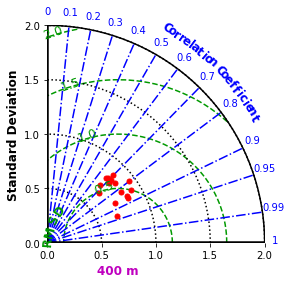

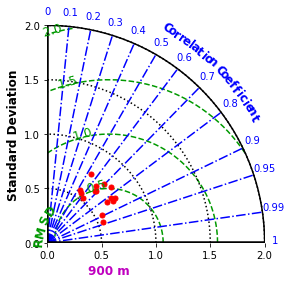

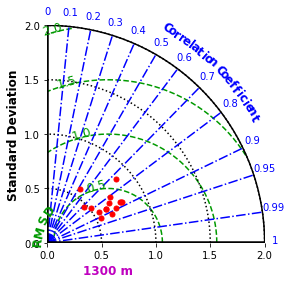

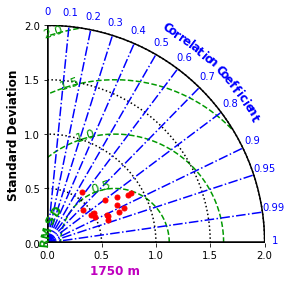

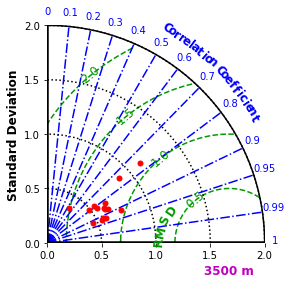

In [4]:
for iz in np.arange(nz):

    plt.figure()
    sdd=srx[iz,:]
    crmsd=srx[iz,:]     # these are just dummy placeholder values but they don't matter
    r=rx[iz,:]
    sdmax = np.ceil(np.max(sdd))
    sm.taylor_diagram(sdd,crmsd,r,axismax=2.,checkStats='on',titleObs=str(z_ac[zlevels[iz]])+' m')